In [ ]:
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from keras.datasets import reuters
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import models, layers
from keras.optimizers import Adam

In [27]:
def preprocess_text(column):
    # Convert to string and lowercase
    column = column.astype(str).str.lower()

    # Remove punctuation
    column = column.apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    column = column.apply(lambda text: " ".join([word for word in text.split() if word not in stop_words]))

    # Count word frequencies
    cnt = Counter()
    for text in column:
        for word in text.split():
            cnt[word] += 1

    # Remove common words
    common_words = set([w for (w, wc) in cnt.most_common(10)])
    column = column.apply(lambda text: " ".join([word for word in text.split() if word not in common_words]))

    # Remove rare words
    rare_words = set([w for (w, wc) in cnt.most_common()[:-11:-1]])
    column = column.apply(lambda text: " ".join([word for word in text.split() if word not in rare_words]))

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    column = column.apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))

    # Remove emojis
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"
                                   u"\U0001F300-\U0001F5FF"
                                   u"\U0001F680-\U0001F6FF"
                                   u"\U0001F1E0-\U0001F1FF"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    column = column.apply(remove_emoji)

    # Remove URLs
    def remove_urls(text):
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        return url_pattern.sub(r'', text)

    column = column.apply(remove_urls)

    # Remove HTML tags
    column = column.apply(lambda text: BeautifulSoup(text, "lxml").text)

    return column

# Convert list to DataFrame and then use preprocess_text function on a Series
X_train_df = pd.DataFrame({'text': X_train})
X_test_df = pd.DataFrame({'text': X_test})

X_train = preprocess_text(X_train_df['text'])
X_test = preprocess_text(X_test_df['text'])


In [46]:
# Load and preprocess data
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=10000)

word_index = reuters.get_word_index()
index_to_word = {index: word for word, index in word_index.items()}

def decode_review(encoded_review):
    return ' '.join([index_to_word.get(i - 3, '?') for i in encoded_review])

# Decode the train and test data
X_train = [decode_review(sequence) for sequence in X_train]
X_test = [decode_review(sequence) for sequence in X_test]

X_train_df = pd.DataFrame({'text': X_train})
X_test_df = pd.DataFrame({'text': X_test})

X_train_clean = preprocess_text(X_train_df['text'])
X_test_clean = preprocess_text(X_test_df['text'])

# Tokenizer to vectorize the text corpus
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_clean)

X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# One-hot encoding the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Splitting the training data
X_val = X_train_pad[:1000]
partial_X_train = X_train_pad[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

# Building the model
model = models.Sequential()
model.add(layers.Embedding(input_dim=10000, output_dim=64, input_length=100))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dense(46, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val))


Train on 7982 samples, validate on 1000 samples
Epoch 1/50
7982/7982 [==============================] - 21s 3ms/step - loss: 2.7579 - acc: 0.3504 - val_loss: 2.3921 - val_acc: 0.3540
Epoch 2/50
7982/7982 [==============================] - 18s 2ms/step - loss: 2.4098 - acc: 0.3514 - val_loss: 2.3898 - val_acc: 0.3540
Epoch 3/50
7982/7982 [==============================] - 18s 2ms/step - loss: 2.3898 - acc: 0.3514 - val_loss: 2.3797 - val_acc: 0.3540
Epoch 4/50
7982/7982 [==============================] - 17s 2ms/step - loss: 2.3649 - acc: 0.3522 - val_loss: 2.3196 - val_acc: 0.3530
Epoch 5/50
7982/7982 [==============================] - 19s 2ms/step - loss: 2.1326 - acc: 0.4054 - val_loss: 1.8564 - val_acc: 0.5010
Epoch 6/50
7982/7982 [==============================] - 18s 2ms/step - loss: 1.7917 - acc: 0.5256 - val_loss: 1.7261 - val_acc: 0.5320
Epoch 7/50
7982/7982 [==============================] - 18s 2ms/step - loss: 1.6432 - acc: 0.5717 - val_loss: 1.6400 - val_acc: 0.5730
Epoch 8

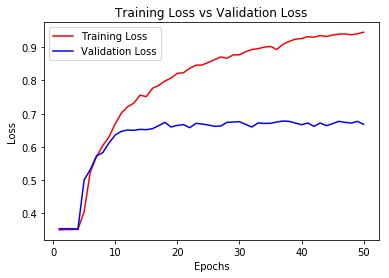

In [49]:
import matplotlib.pyplot as plt
loss = history.history['acc']
val_loss = history.history['val_acc']

epochs = range(1,len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()